# Questão 2 - Operação de Turbofan no Ponto de Projeto

![turbofan_termodynamic_scheme](images/turbofan.svg)


In [1]:
import model_reference as mf
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
warnings.filterwarnings('ignore')

## a)
Para situação de temperatura na saída da câmara de combustão de 1700 K, razão de compressão no compressor de 20, razão de pressão no fan de 1,4; varie a razão de passagem de zero (motor turbojato) até o máximo possível para estas condições de operação ao nível do mar e início da decolagem (Mach 0). 

* Em função da razão de passagem, apresente o comportamento do empuxo específico e consumo específico.

* Admitindo que a vazão de ar para o motor de razão de passagem igual zero (turbojato) é 100 kg/s, determine qual a vazão total de ar (total) e o consumo de combustível para as versões com razão de passagem diferente de zero de tal forma a propiciar o mesmo empuxo que a versão turbojato.

In [2]:
model_parameters = {
    # Atmospheric condition ##############################################
    'pa': 101.3, # [kPa]
    'ta': 288.3, # [K]
    'r': 288.3,  # [J/(kg*K)] Air Gas Constant
    # Components isentropic efficiencies #################################
    'n_d': 0.97,  # Difuser (Inlet)
    'n_f': 0.85,  # Fan
    'n_c': 0.85,  # High Pressure Compressor
    'n_b': 1.0,   # Combustion Chamber
    'n_t': 0.9,   # Compressor Turbine
    'n_tf': 0.9,  # Fan turbine
    'n_n': 0.98,  # Turbine Nozzle
    'n_nf': 0.98, # Fan Nozzle
    # Average air Cp/Cv inside each component ############################
    'gamma_d': 1.4,   # Difuser (Inlet)
    'gamma_f': 1.4,   # Fan
    'gamma_c': 1.37,  # High Pressure Compressor
    'gamma_b': 1.35,  # Combustion Chamber
    'gamma_t': 1.33,  # Compressor Turbine
    'gamma_tf': 1.33, # Fan turbine
    'gamma_n': 1.36,  # Turbine Nozzle
    'gamma_nf': 1.40, # Fan Nozzle
    # Engine parameters ##################################################
    'prc': 20,         # Crompressor Pressure Ratio
    'prf': 1.4,        # Fan Pressure Ratio
    'bypass_ratio': 0, # Initial value
    # Fuel parameters ####################################################
    'pc_fuel': 45000, # [kJ/kg] Heat of Combustion of the fuel
    'cp_fuel': 1.110, # [kJ/(kg*K)] Specific Heat in the combustion chamber
    # Operating Conditions ###############################################
    't04': 1700,        # [K] Combustion Chamber Temperature
    'mach': 0.0,        # Aircraft Mach number
    'mass_flow': 100.0, # [kg/s] Inlet mass flow
    }

summarise_target = [
    'n1',
    'u_s',
    'hot_mass_flow',
    'hot_specific_thrust',
    'cold_mass_flow',
    'cold_specific_thrust',
    'bypass_ratio', 
    'TSFC',
    'thrust_total',
    'specific_thrust',
    ]

# 2a) PART 1 ###################################################################

results = pd.DataFrame()
results.index = results.index.set_names('bpr')

ratios = np.concatenate((np.arange(0, 10, 0.2), np.arange(10, 12, 0.02)))
for bpr in ratios:
    model_parameters["bypass_ratio"] = bpr
    turbofan = mf.TurboFan(model_parameters)

    results[bpr] = (
        turbofan.sumarise().
        append(turbofan.sumarise_results()).
        loc[summarise_target]
        )


results

,0.00,0.20,0.40,0.60,0.80,1.00,1.20,1.40,1.60,1.80,...,11.80,11.82,11.84,11.86,11.88,11.90,11.92,11.94,11.96,11.98
bpr,,,,,,,,,,,,,,,,,,,,,
n1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
u_s,964.221095,955.690980,947.073698,938.366654,929.567125,920.672251,911.679027,902.584288,893.384705,884.076762,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hot_mass_flow,99.923311,83.269426,71.373793,62.452069,55.512950,49.961655,45.419687,41.634713,38.432043,35.686897,...,7.806509,7.794330,7.782189,7.770086,7.758021,7.745993,7.734002,7.722049,7.710132,7.698252
hot_specific_thrust,986.681923,977.953105,969.135090,960.225222,951.220714,942.118641,932.915925,923.609332,914.195450,904.670686,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
cold_mass_flow,0.000000,16.653885,28.549517,37.471241,44.410360,49.961655,54.503624,58.288598,61.491268,64.236414,...,92.116802,92.128981,92.141121,92.153224,92.165290,92.177318,92.189308,92.201262,92.213179,92.225059
cold_specific_thrust,0.000000,48.359620,96.719241,145.078861,193.438481,241.798101,290.157722,338.517342,386.876962,435.236582,...,2853.217596,2858.053558,2862.889520,2867.725482,2872.561444,2877.397406,2882.233368,2887.069330,2891.905292,2896.741254
bypass_ratio,0.000000,0.200000,0.400000,0.600000,0.800000,1.000000,1.200000,1.400000,1.600000,1.800000,...,11.800000,11.820000,11.840000,11.860000,11.880000,11.900000,11.920000,11.940000,11.960000,11.980000
TSFC,0.023609,0.022697,0.021855,0.021075,0.020350,0.019676,0.019046,0.018456,0.017904,0.017385,...,0.008164,0.008150,0.008137,0.008123,0.008109,0.008096,0.008082,0.008068,0.008055,0.008042
thrust_total,98.592524,85.460471,76.074067,69.028527,63.543409,59.150440,55.551622,52.548282,50.002870,47.817132,...,22.273668,22.276613,22.279548,22.282475,22.285392,22.288300,22.291200,22.294090,22.296972,22.299844


Razão de passagem máxima: 10.84


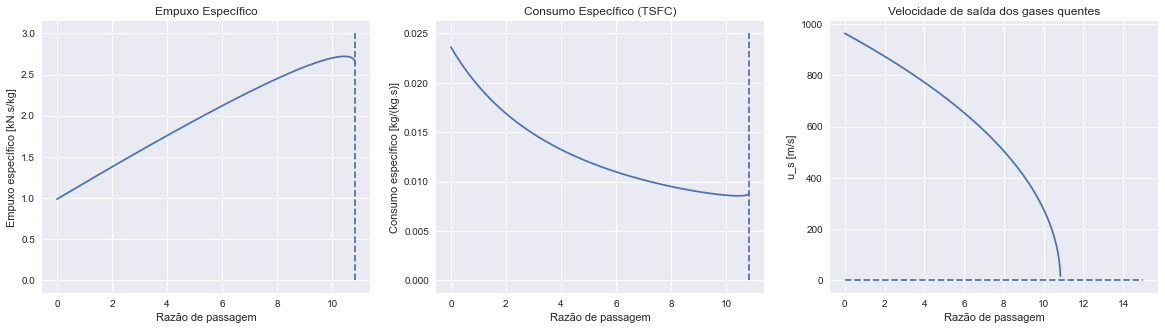

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
bpr_limit = results.T['u_s'].dropna().idxmin()

plt.sca(ax[0])
plt.plot(results.loc['specific_thrust',0:bpr_limit])
plt.title('Empuxo Específico')
plt.xlabel('Razão de passagem')
plt.ylabel('Empuxo específico [kN.s/kg]')
plt.vlines(x=bpr_limit, ymin=0, ymax=3, linestyles='--')

plt.sca(ax[1])
plt.plot(results.loc['TSFC',0:bpr_limit])
plt.title('Consumo Específico (TSFC)')
plt.xlabel('Razão de passagem')
plt.ylabel('Consumo específico [kg/(kg.s)]')
plt.vlines(x=bpr_limit, ymin=0, ymax=0.025, linestyles='--')

plt.sca(ax[2])
plt.plot(results.loc['u_s',0:bpr_limit])
plt.title('Velocidade de saída dos gases quentes')
plt.xlabel('Razão de passagem')
plt.ylabel('u_s [m/s]')
plt.hlines(y=0, xmin=0, xmax=15, linestyles='--')

print(f"Razão de passagem máxima: {bpr_limit:0.2f}")

In [12]:
# 2a) PART 2 ###################################################################
"""
1. vazão total de ar (total)
2. consumo de combustível 

para as versões com razão de passagem diferente de zero de tal forma a propiciar o 

!! mesmo empuxo que a versão turbojato !!

"""

results_2 = pd.DataFrame()
results_2.index = results_2.index.set_names('bpr')

model_parameters["bypass_ratio"] = 0 # Turbojet configuration
model_parameters['mass_flow'] = 100 # [kg/s] initial value
tubojet = mf.TurboFan(model_parameters)
turbojet_thrust = float(tubojet.sumarise_results().loc['thrust_total'])

summarise_target_2 = [
    'fuel_consumption',
    'thrust_total',
    'TSFC',
    'mass_flow'
]

step=0.25
print("Iterating...")
for bpr in np.arange(0, bpr_limit+step, step):
    model_parameters["bypass_ratio"] = bpr
    inlet_mass_flow = 100 # [kg/s]
    tol = 1e-5
    diff = 1.0
    while abs(diff) > tol:
        model_parameters["mass_flow"] = inlet_mass_flow
        turbofan = mf.TurboFan(model_parameters)

        turbofan_thrust = float(turbofan.sumarise_results().loc['thrust_total'])
        diff = (turbofan_thrust - turbojet_thrust)/turbojet_thrust
        inlet_mass_flow = inlet_mass_flow - 100*diff # Update mass flow (increase if thrust is lower)

    results_2[bpr] = (
        turbofan.sumarise().
        append(turbofan.sumarise_results()).
        loc[summarise_target_2]
        )
print("Done!")

results_2

Iterating...
Done!


,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,...,8.75,9.00,9.25,9.50,9.75,10.00,10.25,10.50,10.75,11.00
bpr,,,,,,,,,,,,,,,,,,,,,
fuel_consumption,2.327641,2.216387,2.115553,2.023761,1.939854,1.862867,1.791978,1.726517,1.665878,1.609564,...,0.897111,0.885533,0.874910,0.865339,0.856995,0.850178,0.845484,0.844343,0.852574,0.863463
thrust_total,98.592524,98.592261,98.591856,98.591768,98.591862,98.592006,98.591730,98.591992,98.591862,98.591765,...,98.591752,98.591610,98.591722,98.591567,98.591664,98.591734,98.591775,98.591773,98.591651,98.591710
TSFC,0.023609,0.022480,0.021458,0.020527,0.019676,0.018895,0.018176,0.017512,0.016897,0.016326,...,0.009099,0.008982,0.008874,0.008777,0.008692,0.008623,0.008576,0.008564,0.008648,0.008758
mass_flow,99.923311,118.934127,136.227919,152.036585,166.552019,179.934781,192.319594,203.823569,214.543520,224.565252,...,375.492856,380.150425,384.980008,390.055509,395.491698,401.470181,408.327770,416.838082,430.051637,444.811567


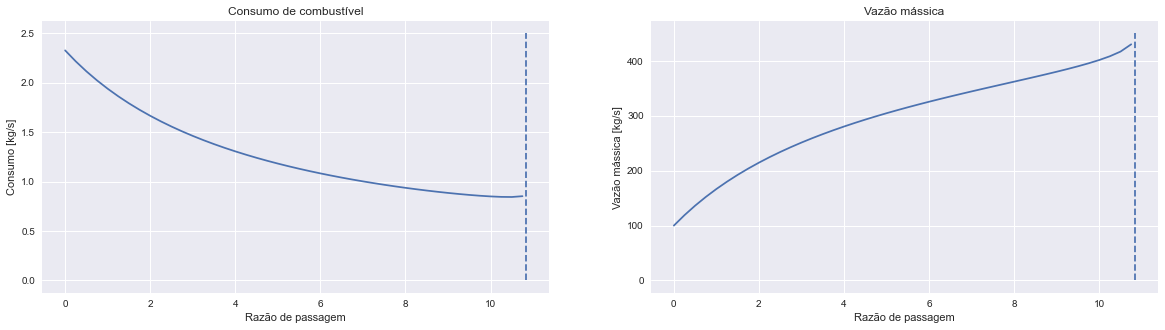

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
bpr_limit = results.T['u_s'].dropna().idxmin()

plt.sca(ax[0])
plt.plot(results_2.loc['fuel_consumption',0:bpr_limit])
plt.title('Consumo de combustível')
plt.xlabel('Razão de passagem')
plt.ylabel('Consumo [kg/s]')
plt.vlines(x=bpr_limit, ymin=0, ymax=2.5, linestyles='--')

plt.sca(ax[1])
plt.plot(results_2.loc['mass_flow',0:bpr_limit])
plt.title('Vazão mássica')
plt.xlabel('Razão de passagem')
plt.ylabel('Vazão mássica [kg/s]')
plt.vlines(x=bpr_limit, ymin=0, ymax=450, linestyles='--')

In [23]:
turbofan.sumarise().append(turbofan.sumarise_results())

,1
bypass_ratio,14.750000
cp_comb,1.110000
f,0.023294
gamma_b,1.350000
gamma_c,1.370000
gamma_d,1.400000
gamma_f,1.400000
gamma_n,1.360000
gamma_nf,1.400000
gamma_t,1.330000


## c)
Partindo a configuração inicial de motor turbofan: temperatura na saída da câmara de combustão de 1700 K, razão de compressão no compressor de 20, razão de pressão no fan de 1,4 e razão de passagem 5. Para operação ao nível do mar e início da decolagem (Mach 0), 

* Primeiramente verifique se para esta configuração seria possível aumentar a razão de passagem, mantendo todas as outras condições. 
* Depois diminua gradativamente a razão de pressão do compressor e encontre novamente a máxima razão de passagem para cada razão de compressão. Apresente a relação entre a razão de compressão do compressor e a razão de passagem, empuxo específico e consumo especifico.

In [ ]:
model_parameters = {
    # Atmospheric condition ##############################################
    'pa': 101.3, # [kPa]
    'ta': 288.3, # [K]
    'r': 288.3,  # [J/(kg*K)] Air Gas Constant
    # Components isentropic efficiencies #################################
    'n_d': 0.97,  # Difuser (Inlet)
    'n_f': 0.85,  # Fan
    'n_c': 0.85,  # High Pressure Compressor
    'n_b': 1.0,   # Combustion Chamber
    'n_t': 0.9,   # Compressor Turbine
    'n_tf': 0.9,  # Fan turbine
    'n_n': 0.98,  # Turbine Nozzle
    'n_nf': 0.98, # Fan Nozzle
    # Average air Cp/Cv inside each component ############################
    'gamma_d': 1.4,   # Difuser (Inlet)
    'gamma_f': 1.4,   # Fan
    'gamma_c': 1.37,  # High Pressure Compressor
    'gamma_b': 1.35,  # Combustion Chamber
    'gamma_t': 1.33,  # Compressor Turbine
    'gamma_tf': 1.33, # Fan turbine
    'gamma_n': 1.36,  # Turbine Nozzle
    'gamma_nf': 1.40, # Fan Nozzle
    # Engine parameters ##################################################
    'prc': 20,         # Crompressor Pressure Ratio
    'prf': 1.4,        # Fan Pressure Ratio (Initial value)
    'bypass_ratio': 5, # Initial value
    # Fuel parameters ####################################################
    'pc_fuel': 45000, # [kJ/kg] Heat of Combustion of the fuel
    'cp_fuel': 1.110, # [kJ/(kg*K)] Specific Heat in the combustion chamber
    # Operating Conditions ###############################################
    't04': 1700,        # [K] Combustion Chamber Temperature
    'mach': 0.0,        # Aircraft Mach number
    'mass_flow': 100.0, # [kg/s] Inlet mass flow
    }

# 2c) PART 1 ###################################################################
"""verifique se para esta configuração seria possível aumentar a razão de passagem, mantendo todos as outras condições"""

